# Assignment 2: XAI
Task: Predict the diagnosis for given x-ray images
- Task Information: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/
- Data Information: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data
<br>

Report
- Task definition
- Data description (results of data exploration)
- Description of baseline method
- Desciption of hyperparameter optimization
- Results: A table for...
    - Baseline results (repication of exisiting method)
    - Results of hyperparameter optimization/alternative approach
    - Extensive analysis of best model using XAI techniques
- Brief conclusion: Which feature respresentation/model worked the best and why

## Code

In [ ]:
# Import packages
import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

### 1.0 Dataset Exploration
- Download dataset from Kaggle
- Explore dataset to under input features (images), classes (normal vs. pneumonia), and distribution of data
- Visualize sample images for both clases, along with their labels
    - Can use https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy as reference (do not just copy)

In [29]:
# Get dataset directories 
main_dir = 'chest-x-ray'

test_dir = os.path.join(main_dir, 'test')
train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'val')

# Set labels
labels=['NORMAL', 'PNEUMONIA']

# Set preferred image size for reshaping later
img_size = 150

# Function for data
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
            data.append([resized_arr, class_num])
    return data

# Load dataset
train = get_data(train_dir)
test = get_data(test_dir)
val = get_data(val_dir)

<Axes: ylabel='count'>

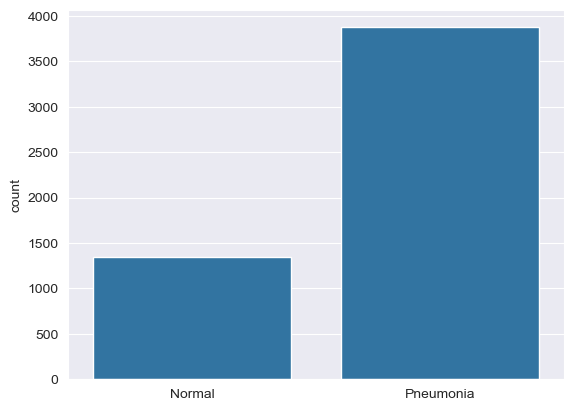

In [30]:
# Map labels to strings
l = []
for i in train:
    if i[1] == 1:
        l.append("Pneumonia")
    else:
        l.append("Normal")

sns.set_style('darkgrid')
sns.countplot(x=l)


Text(0.5, 1.0, 'PNEUMONIA')

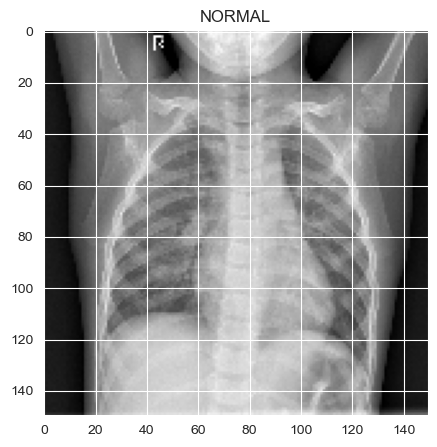

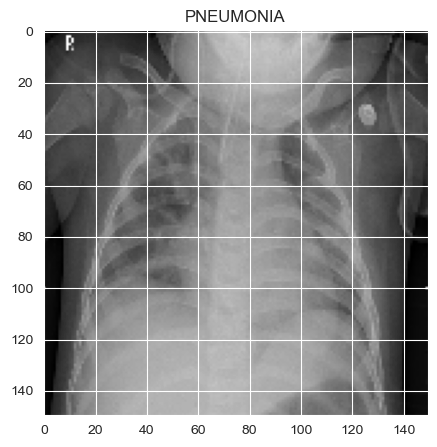

In [31]:
# Show single example for pneumonia and normal
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [32]:
# Seperate features and labels
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [33]:
# Normalize the data
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255

# Resize data 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

Data Augmentation:
- Mirroring/flipping
- Tilting
- Contrast/hue/saturation
- Cropping/size
Makes classifier more robust and increases dataset size 

In [34]:
# Increase data set size with data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        # Sets input mean to 0 (not used)
        featurewise_center=False,  
        # Sets sample means to 0 (not used)
        samplewise_center=False,  
        # Divides inputs by std of dataset (not used)
        featurewise_std_normalization=False,  
        # Divides input by its std (not used)
        samplewise_std_normalization=False,  
        # ZCA whitening (not used)
        zca_whitening=False,  
        # Randomly rotate images
        rotation_range = 30,  
        # Randomly zoom
        zoom_range = 0.2, 
        # Random horizontal shift
        width_shift_range=0.1, 
        # Random vertical shift
        height_shift_range=0.1,  
        # Randomly horizontal flip
        horizontal_flip = True, 
        # Random vertical flip (not used)
        vertical_flip=False)  
# Fit data to train set
datagen.fit(x_train)

### 2.0 CNN Baseline
- Use example CNN architecture provide in Kaggle code as a base. Understand role of key components like convolutional layers, pooling layers, and fully connected layers
- Train model on training dataset
- Track and report model performance metrics (accuracy, loss) during training and on the test dataset

In [35]:
# Create a model function
def get_model(input_shape, num_filters, kernel_size, stride, dropout):
    model = Sequential()

    # LAYER 1
    model.add(Conv2D(num_filters, kernel_size=kernel_size, strides=stride, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # LAYER 2
    model.add(Conv2D(num_filters * 2, kernel_size=kernel_size, strides=stride, padding='same', activation='relu'))
    model.add(Dropout(dropout/2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # LAYER 3
    model.add(Conv2D(num_filters, kernel_size=kernel_size, strides=stride, padding='same', activation='relu'))
    model.add(Dropout(dropout/2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # LAYER 4
    model.add(Conv2D(num_filters * 4, kernel_size=kernel_size, strides=stride, padding='same', activation='relu'))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    # LAYER 5
    model.add(Conv2D(num_filters * 2, kernel_size=kernel_size, strides=stride, padding='same', activation='relu'))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile and return model
    model.compile(optimizer="rmsprop", loss='binary_crossentropy', metrics=['accuracy'])
    return model

# For grayscale images
input_shape = (img_size, img_size, 1)  
# Get model
model = get_model(input_shape, num_filters=32, kernel_size=(3,3), stride=1, dropout=0.2)
# Use learning rate reduction for adaptive learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.00001)
# Fit model
history = model.fit(x_train, y_train, batch_size=32, 
                    epochs=6, 
                    validation_data=(x_val, y_val), 
                    callbacks=[learning_rate_reduction])

# Evaluate the model on the test set
print("Loss: ", model.evaluate(x_test, y_test)[0])
print("Accuracy: ", model.evaluate(x_test, y_test)[1] * 100, "%")


c:\Users\ellae\anaconda3\envs\DS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 689ms/step - accuracy: 0.8445 - loss: 0.6660 - val_accuracy: 0.5000 - val_loss: 6.5056 - learning_rate: 0.0010
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 676ms/step - accuracy: 0.9583 - loss: 0.1216 - val_accuracy: 0.5000 - val_loss: 8.2661 - learning_rate: 0.0010
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.9670 - loss: 0.0895
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 676ms/step - accuracy: 0.9670 - loss: 0.0895 - val_accuracy: 0.5000 - val_loss: 5.1020 - learning_rate: 0.0010
Epoch 4/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 680ms/step - accuracy: 0.9884 - loss: 0.0302 - val_accuracy: 0.5625 - val_loss: 2.0100 - learning_rate: 3.0000e-04
Epoch 5/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 112s 686ms/step - accuracy: 0.9884 - loss: 0.0260 - val_accuracy: 0.9375 - val_loss: 0.0843 - learning_rate: 3.0000e-04
Epoch 6/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 681ms/step - accurac

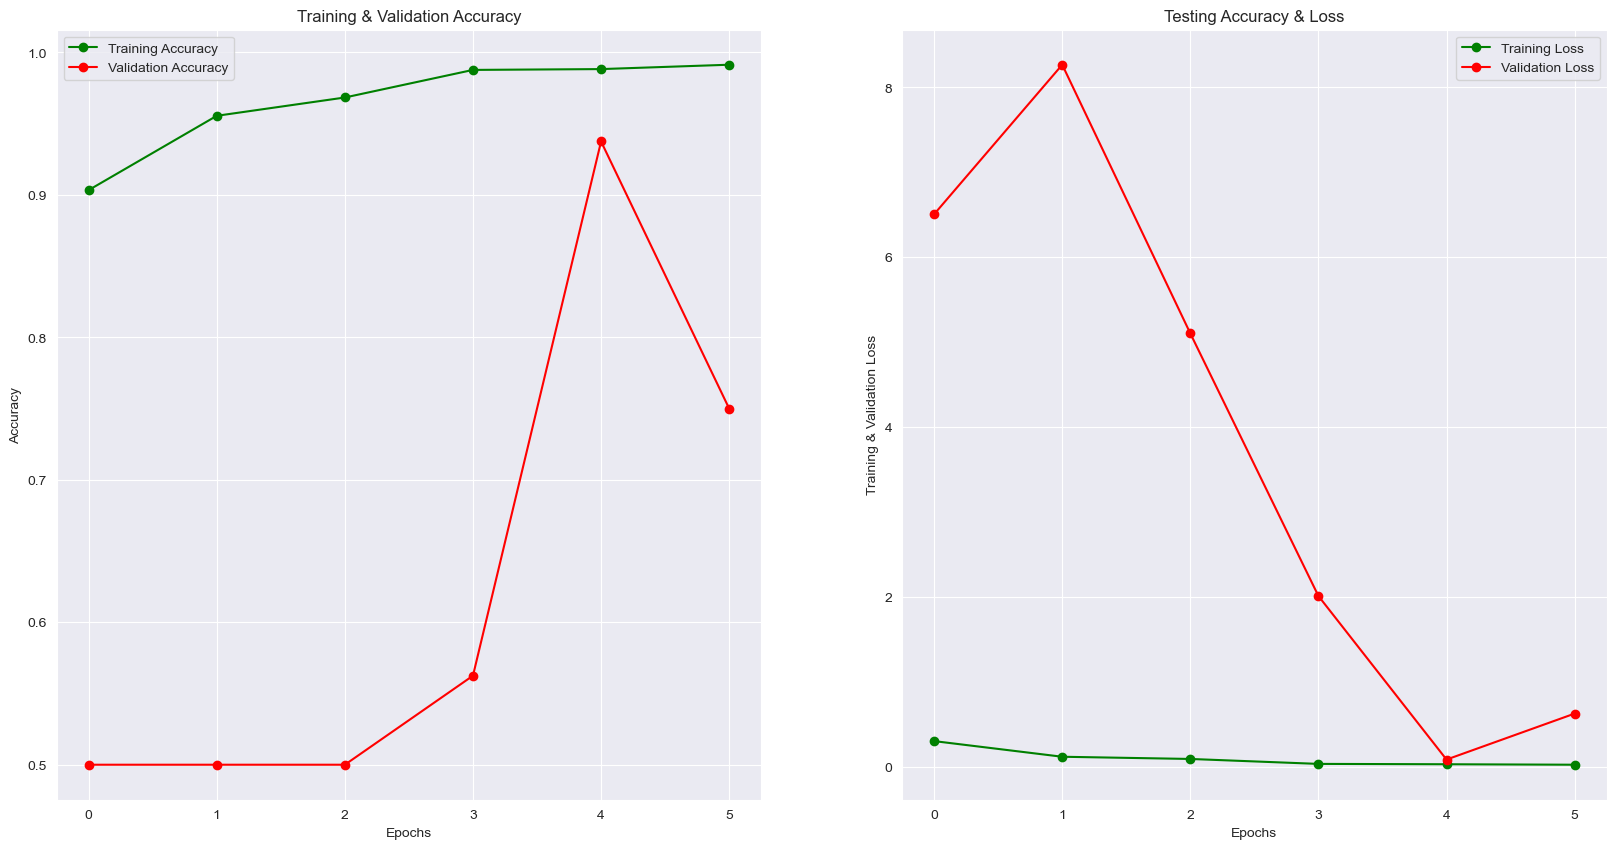

In [36]:
# Create graph over epochs to plot accuracy and loss
epochs = [i for i in range(6)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

### 3.0 Performance Evaluation
- After training, evaluate model on test set
- Present the confusion matrix, precision, recall, and F1 score for baseline model


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       1.00      0.27      0.43       234
   PNEUMONIA       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.85      0.64      0.63       624
weighted avg       0.81      0.73      0.67       624


Precision: 0.6964
Recall: 1.0000
F1 Score: 0.8211


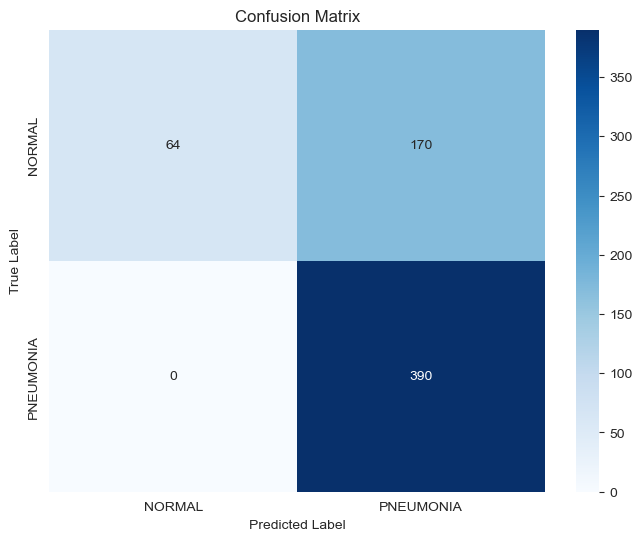


Test Accuracy: 0.7276
Test Loss: 2.3149


In [37]:
# Predict on test set
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

# Calculate evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=labels))

precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


### 4.0 Hyperparameter Optimization & Alternative Models
- Use an HPO method (SMAC3, Bayesian optimization, etc) to try to improve the current model; use a realistic budget (do no run experiments for more than a day)
- Try a different model (machline learning technique) for the given task, provide motivation as to why
- Present confusion matrix, precision, recall, and F1 score on train and test set for the final optimized CNN model and the alternative ML model

In [38]:
# Hyperparameter optimization
# Bayesian optimization
from bayes_opt import BayesianOptimization

# Optimize kernel, strides, dropout
# Define parameter search space
param_space = {
    'kernel': (2,5),
    'num_filters': (16, 64),
    'stride': (1,2),
    'dropout': (0.05,0.6), 
    'lr': (1e-5, 1e-2)
}

# Input shape for greyscale images
input_shape = (img_size, img_size, 1)

# Objective function
def CNN_objective(num_filters, kernel, stride, dropout, lr):
    num_filters = int(num_filters)
    kernel = int(kernel)
    stride = int(stride)

    model = get_model(input_shape, num_filters=num_filters, kernel_size=(kernel, kernel), stride=(stride, stride), dropout=dropout)
    
    optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        epochs=3,
                        batch_size=32,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    val_acc = history.history['val_accuracy'][-1]
    return val_acc

# Bayesian optimizer
optimizer = BayesianOptimization(
    f = CNN_objective,
    pbounds = param_space,
    random_state = 42,
    verbose = 1
)

# Maximize validation accuracy
optimizer.maximize(init_points = 4, n_iter = 2)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

# Show best values
print(optimizer.max)

|   iter    |  target   |  dropout  |  kernel   |    lr     | num_fi... |  stride   |
-------------------------------------------------------------------------------------


c:\Users\ellae\anaconda3\envs\DS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.7861 - loss: 2.2350 - val_accuracy: 0.5000 - val_loss: 8.8249
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.9208 - loss: 0.2210 - val_accuracy: 0.5000 - val_loss: 2.2035
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.9497 - loss: 0.1536 - val_accuracy: 0.5000 - val_loss: 6.1522
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 150s 900ms/step - accuracy: 0.7911 - loss: 2.5206 - val_accuracy: 0.5000 - val_loss: 9.5583
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 909ms/step - accuracy: 0.9286 - loss: 0.2331 - val_accuracy: 0.5000 - val_loss: 40.6865
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 153s 936ms/step - accuracy: 0.9499 - loss: 0.1567 - val_accuracy: 0.5000 - val_loss: 20.9689
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 584ms/step - accuracy: 0.7650 - loss: 2.3185 - val_accuracy: 0.5000 - val_loss: 28.9105
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 569ms/step - accuracy: 0.9279 - loss: 0.1986 - 

c:\Users\ellae\anaconda3\envs\DS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 372ms/step - accuracy: 0.8062 - loss: 0.8680 - val_accuracy: 0.5000 - val_loss: 5.4573
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 373ms/step - accuracy: 0.9350 - loss: 0.1742 - val_accuracy: 0.5000 - val_loss: 14.5793
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 375ms/step - accuracy: 0.9561 - loss: 0.1298 - val_accuracy: 0.5000 - val_loss: 8.7033


c:\Users\ellae\anaconda3\envs\DS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 539ms/step - accuracy: 0.8446 - loss: 0.6694 - val_accuracy: 0.5000 - val_loss: 9.6700
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 515ms/step - accuracy: 0.9541 - loss: 0.1338 - val_accuracy: 0.5000 - val_loss: 11.0037
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 512ms/step - accuracy: 0.9562 - loss: 0.1219 - val_accuracy: 0.5000 - val_loss: 7.7896
Iteration 0: 
	{'target': 0.5, 'params': {'dropout': 0.2559970653660493, 'kernel': 4.852142919229749, 'lr': 0.007322619478695937, 'num_filters': 44.73560724145776, 'stride': 1.1560186404424364}}
Iteration 1: 
	{'target': 0.5, 'params': {'dropout': 0.13579698618491143, 'kernel': 2.1742508365045983, 'lr': 0.008663099696291603, 'num_filters': 44.853520563674024, 'stride': 1.7080725777960455}}
Iteration 2: 
	{'target': 0.5625, 'params': {'dropout': 0.06132147186269135, 'kernel': 4.909729556485983, 'lr': 0.008326101981596213, 'num_filters': 26.192277312557255, 'stride': 1.1818249672071006}}
Iteration 3: 
	{

In [48]:
from keras.optimizers import RMSprop
# Get best parameters
best_params = optimizer.max['params']

num_filters = int(best_params['num_filters'])
kernel = int(best_params['kernel'])
stride = int(best_params['stride'])
dropout = best_params['dropout']
lr = best_params['lr']

# Make model with best paramters
best_model = get_model(
    input_shape=input_shape,
    num_filters=num_filters,
    kernel_size=(kernel, kernel),
    stride=(stride, stride),
    dropout=dropout
)

best_model.compile(optimizer=RMSprop(learning_rate=lr),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Train 
best_model.fit(x_train, y_train, epochs=5, batch_size=32, verbose=1)


c:\Users\ellae\anaconda3\envs\DS\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 95s 559ms/step - accuracy: 0.7695 - loss: 2.4877
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 537ms/step - accuracy: 0.9281 - loss: 0.1973
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 572ms/step - accuracy: 0.9501 - loss: 0.1572
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 573ms/step - accuracy: 0.9621 - loss: 0.1174
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 93s 573ms/step - accuracy: 0.9716 - loss: 0.0883


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.93      0.50      0.65       234
   PNEUMONIA       0.77      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.74      0.75       624
weighted avg       0.83      0.80      0.78       624


Precision: 0.7651
Recall: 0.9769
F1 Score: 0.8581


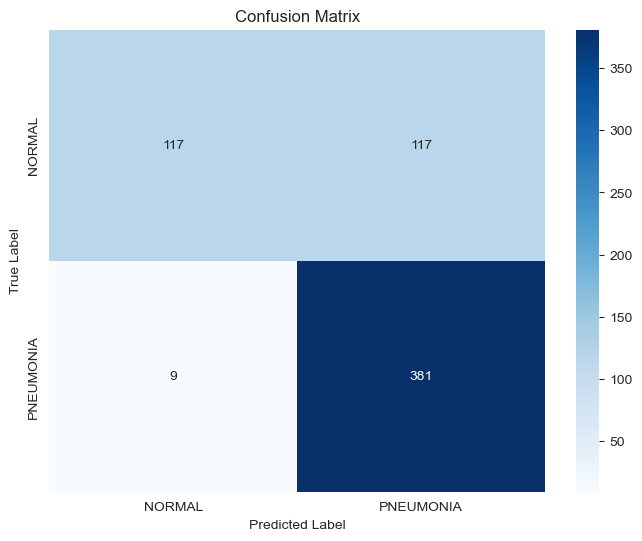


Test Accuracy: 0.7981
Test Loss: 0.6626


In [54]:
# Predict on test set
y_pred_prob = best_model.predict(x_test)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=labels))

# Precision, Recall, F1
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Accuracy & loss
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6616 - loss: 1.1093

163/163 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.6617 - loss: 1.1075 - val_accuracy: 0.5000 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7612 - loss: 0.4995

163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.7613 - loss: 0.4992 - val_accuracy: 0.6875 - val_loss: 0.6206 - learning_rate: 0.0010
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8461 - loss: 0.3182 - val_accuracy: 0.5625 - val_loss: 0.7421 - learning_rate: 0.0010
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8590 - loss: 0.2756

163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 127ms/step - accuracy: 0.8590 - loss: 0.2756 - val_accuracy: 0.8125 - val_loss: 0.4852 - learning_rate: 0.0010
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - accuracy: 0.8789 - loss: 0.2488 - val_accuracy: 0.5625 - val_loss: 0.8259 - learning_rate: 0.0010
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 126ms/step - accuracy: 0.8802 - loss: 0.2397 - val_accuracy: 0.7500 - val_loss: 0.5782 - learning_rate: 0.0010
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 136ms/step - accuracy: 0.9036 - loss: 0.2308 - val_accuracy: 0.6875 - val_loss: 0.6457 - learning_rate: 0.0010
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9130 - loss: 0.2220 - val_accuracy: 0.7500 - val_loss: 0.5325 - learning_rate: 5.0000e-04
Epoch 9/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9202 - loss: 0.1983 - val_accuracy: 0.6875 - val_loss: 0.7272 - learning_rate: 5.0000e-04
Epoch 10/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step - accuracy: 0.922

163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.9290 - loss: 0.1891 - val_accuracy: 0.8750 - val_loss: 0.4723 - learning_rate: 5.0000e-04
Epoch 13/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9270 - loss: 0.1808 - val_accuracy: 0.7500 - val_loss: 1.0210 - learning_rate: 5.0000e-04
Epoch 14/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.9363 - loss: 0.1635 - val_accuracy: 0.7500 - val_loss: 0.4482 - learning_rate: 5.0000e-04
Epoch 15/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - accuracy: 0.9406 - loss: 0.1628 - val_accuracy: 0.6875 - val_loss: 0.5834 - learning_rate: 5.0000e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5530 - loss: 0.9510

Test accuracy: 0.7468
Test loss: 0.5708
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.95      0.34      0.50       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                 

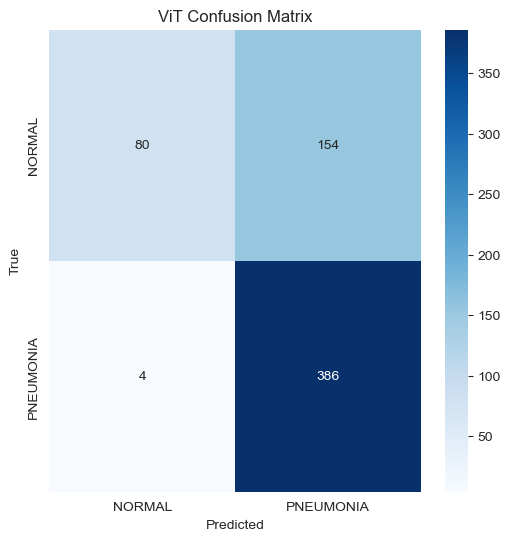

In [63]:
from tensorflow.keras.layers import Lambda

# Set parameters
num_classes = 2
input_shape = (img_size, img_size, 1)
patch_size = 16  
num_patches = (img_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_layers = 4  
mlp_head_units = [256, 128]  

# Convert grayscale to RGB 
x_train_rgb = tensorflow.repeat(x_train, 3, axis=-1)
x_val_rgb = tensorflow.repeat(x_val, 3, axis=-1)
x_test_rgb = tensorflow.repeat(x_test, 3, axis=-1)

# Create ViT classifier
def create_vit_classifier():
    inputs = keras.layers.Input(shape=input_shape)
    
    # Convert to RGB
    rgb = Lambda(lambda x: tensorflow.repeat(x, repeats=3, axis=-1))(inputs)
    
    # Reshape into patches
    patches = keras.layers.Conv2D(
        filters=projection_dim,
        kernel_size=patch_size,
        strides=patch_size,
        padding='valid'
    )(rgb)
    patches = keras.layers.Reshape((num_patches, projection_dim))(patches)
    
    # Add learnable position embedding
    positions = tensorflow.range(start=0, limit=num_patches, delta=1)
    position_embedding = keras.layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )(positions)
    x = patches + position_embedding
    
    # Transformer blocks
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
        
        # Multi-head attention
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        x2 = keras.layers.Add()([attention_output, x])
        
        # Layer normalization 2
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # Multiplayerd perceptron
        x3 = keras.layers.Dense(units=projection_dim * 2, activation=tf.nn.gelu)(x3)
        x3 = keras.layers.Dropout(0.1)(x3)
        x3 = keras.layers.Dense(units=projection_dim)(x3)
        x3 = keras.layers.Dropout(0.1)(x3)
        
        x = keras.layers.Add()([x3, x2])
    
    # Classification head
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.5)(x)
    
    # Add MLP
    for units in mlp_head_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(0.5)(x)
    
    # Output layer
    outputs = keras.layers.Dense(num_classes)(x)
    
    # Create model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile model
vit_model = create_vit_classifier()
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_vit_model.h5", save_best_only=True, monitor="val_accuracy"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=0.00001
    )
]

# Train the model
history = vit_model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
)

# Evaluation
test_loss, test_acc = vit_model.evaluate(x_test, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Generate predictions
y_pred = vit_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.title('ViT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 4.0 Explainable AI
- Inspect misclassification errors and use explainable AI techniques to highlight what the models are focusing on
- Feature importance with Grad-CAM (example at https://keras.io/examples/vision/grad_cam/, https://github.com/ismailuddin/gradcam-tensorflow-2, or https://deel-ai.github.io/xplique/v1.4.0/)
    - Use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which parts of the input images contribute most to the model's predictions
    - Choose 5-10 misclassified samples and use Grad-CAM to inspect which regions the model is focusing on
    - Interpret the results:
        - Are the activations reasonable?
        - Can it be identified why the model made incorrect predictions for chosen samples?
    - Layer-wise Relevance Propagation (LRP) (optional for bonus points)
        - Apply LRP to further analyze how different layers of network contribute to the final predictions
        - Compare insights from LRP with Grad-CAM, are there any differences in how each method highlights the important regions of the image?

Baseline

In [93]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 38, 38, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 38, 38, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 19, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 19, 19, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 10, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 708,164 (2.70 MB)

 Trainable params: 353,761 (1.35 MB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 353,763 (1.35 MB)

In [ ]:
# Get misclassified samples
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

misclassified_indices = np.where(y_pred_classes != y_test)[0]

# Select 5 random misclassified samples
np.random.seed(42)
selected_indices = np.random.choice(misclassified_indices, 5, replace=False)

# Get the last convolutional layer (using model.summary())
last_conv_layer_name = "conv2d_19"  

# Make GradCam heatmap function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create model that maps input to last conv layer to output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Find gradient of top classes
    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of output 
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pooled gradients
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    # Heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # Normalize between 0-1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Convert grayscale to RGB 
    img = np.uint8(255 * img_array)
    img = np.squeeze(img) 
    img = np.stack((img,)*3, axis=-1) 
    
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Jet colormap
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
    # Place heatmap ontop of image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    
    # Display GradCam
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Grad-CAM for misclassified samples
for i, idx in enumerate(selected_indices):
    img_array = x_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]
    
    # Prepare image array 
    img_array_expanded = np.expand_dims(img_array, axis=0)
    
    # Generate heatmap
    heatmap = make_gradcam_heatmap(
        img_array_expanded, 
        model, 
        last_conv_layer_name,
        pred_index=0  
    )
    
    # Display results
    print(f"\nSample {i+1}:")
    print(f"True label: {labels[true_label]}")
    print(f"Predicted label: {labels[pred_label]}")
    print(f"Prediction confidence: {y_pred[idx][0]:.2f}")
    
    # Show original image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(img_array), cmap='gray')
    plt.title(f"Original: {labels[true_label]}")
    plt.axis('off')
    plt.show()
    
    # Show heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()
    
    # Show combined image
    save_and_display_gradcam(img_array, heatmap)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


Hyperparameter Optimized

In [77]:
best_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 150, 150, 26)   │           442 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 150, 150, 26)   │           104 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 75, 75, 26)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 75, 75, 52)     │        21,684 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 75, 75, 52)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 75, 75, 52)     │           208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 38, 38, 52)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 38, 38, 26)     │        21,658 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 38, 38, 26)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 38, 38, 26)     │           104 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 19, 19, 26)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 19, 19, 104)    │        43,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 19, 19, 104)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 19, 19, 104)    │           416 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 10, 10, 104)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 10, 10, 52)     │        86,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 10, 10, 52)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 10, 10, 52)     │           208 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 5, 5, 52)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1300)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       166,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 682,340 (2.60 MB)

 Trainable params: 340,909 (1.30 MB)

 Non-trainable params: 520 (2.03 KB)

 Optimizer params: 340,911 (1.30 MB)

In [ ]:
# Get misclassified samples
y_pred = best_model.predict(x_test)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

misclassified_indices = np.where(y_pred_classes != y_test)[0]

# Select 5 random misclassified samples
np.random.seed(42)
selected_indices = np.random.choice(misclassified_indices, 5, replace=False)

# Get the last convolutional layer (using model.summary())
last_conv_layer_name = "conv2d_64"  

# Make GradCam heatmap function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create model that maps input to last conv layer to output predictions
    grad_model = keras.models.Model(
        model.layers[0].inputs, [model.get_layer(last_conv_layer_name).output, model.output,  dense_25]
    )

    # Find gradient of top classes
    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of output 
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Pooled gradients
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    # Heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # Normalize between 0-1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_array, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Convert grayscale to RGB 
    img = np.uint8(255 * img_array)
    img = np.squeeze(img) 
    img = np.stack((img,)*3, axis=-1) 
    
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Jet colormap
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Create RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
    # Place heatmap ontop of image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    
    # Display GradCam
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Grad-CAM for misclassified samples
for i, idx in enumerate(selected_indices):
    img_array = x_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]
    
    # Prepare image array 
    img_array_expanded = np.expand_dims(img_array, axis=0)
    
    # Generate heatmap
    heatmap = make_gradcam_heatmap(
        img_array_expanded, 
        best_model, 
        last_conv_layer_name,
        pred_index=0  
    )
    
    # Display results
    print(f"\nSample {i+1}:")
    print(f"True label: {labels[true_label]}")
    print(f"Predicted label: {labels[pred_label]}")
    print(f"Prediction confidence: {y_pred[idx][0]:.2f}")
    
    # Show original image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(img_array), cmap='gray')
    plt.title(f"Original: {labels[true_label]}")
    plt.axis('off')
    plt.show()
    
    # Show heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()
    
    # Show combined image
    save_and_display_gradcam(img_array, heatmap)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


ViT

In [ ]:
def make_vit_gradcam_heatmap(img_array, model, last_transformer_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap for ViT models"""
    # Create model that maps input to last transformer layer + output predictions
    grad_model = keras.models.Model(
        model.inputs, 
        [model.get_layer(last_transformer_layer_name).output, model.output]
    )

    # Compute gradient of top predicted class
    with tensorflow.GradientTape() as tape:
        last_transformer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Gradient of output neuron with regard to last transformer output
    grads = tape.gradient(class_channel, last_transformer_output)

    # Pooled gradients 
    pooled_grads = tensorflow.reduce_mean(grads, axis=1)

    # Heatmap
    last_transformer_output = last_transformer_output[0]
    heatmap = last_transformer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # Normalize between 0-1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_vit_gradcam(img_array, heatmap, patch_size=16, alpha=0.4):
    """Display Grad-CAM for ViT models with patch visualization"""
    img_size = img_array.shape[0]
    num_patches = img_size // patch_size
    
    # Convert grayscale to RGB for visualization
    img = np.uint8(255 * img_array)
    img = np.squeeze(img)  
    img = np.stack((img,)*3, axis=-1) 
    
    # Reshape heatmap to patch grid and resize to original image size
    patch_heatmap = heatmap.reshape((num_patches, num_patches))
    heatmap_resized = tensorflow.image.resize(
        patch_heatmap[..., tensorflow.newaxis], 
        (img_size, img_size),
        method='nearest'
    ).numpy().squeeze()
    
    # Rescale heatmap to 0-255
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Use jet colormap
    jet = matplotlib.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap_resized]
    
    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_size, img_size))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)
    
    # Put heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)
    
    # Display Grad CAM
    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Identify misclassified samples from the test set
y_pred = vit_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

misclassified_indices = np.where(y_pred_classes != y_test)[0]

# Select 5 random misclassified samples
np.random.seed(42)
selected_indices = np.random.choice(misclassified_indices, 5, replace=False)

# Get the last transformer layer name from your model
last_transformer_layer_name = "layer_normalization_46"  

# Generate Grad-CAM for each misclassified sample
for i, idx in enumerate(selected_indices):
    img_array = x_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred_classes[idx]
    
    # Prepare image array 
    img_array_expanded = np.expand_dims(img_array, axis=0)
    
    # Generate heatmap
    heatmap = make_vit_gradcam_heatmap(
        img_array_expanded, 
        vit_model, 
        last_transformer_layer_name,
        pred_index=pred_label
    )
    
    # Display results
    print(f"\nSample {i+1}:")
    print(f"True label: {labels[true_label]}")
    print(f"Predicted label: {labels[pred_label]}")
    print(f"Prediction confidence: {np.max(y_pred[idx]):.2f}")
    
    # Show original image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(img_array), cmap='gray')
    plt.title(f"Original: {labels[true_label]}")
    plt.axis('off')
    plt.show()
    
    # Show patch attention heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(heatmap.reshape(9, 9), cmap='jet') 
    plt.title("Patch Attention Heatmap")
    plt.colorbar()
    plt.axis('off')
    plt.show()
    
    # Show superimposed image
    save_and_display_vit_gradcam(img_array, heatmap, patch_size=16)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


ValueError: operands could not be broadcast together with shapes (1248,) (624,) 

## Report
- Task definition
- Data description (results of data exploration)
- Description of baseline method
- Desciption of hyperparameter optimization
- Results: A table for...
    - Baseline results (repication of exisiting method)
    - Results of hyperparameter optimization/alternative approach
    - Extensive analysis of best model using XAI techniques
- Brief conclusion: Which feature respresentation/model worked the best and why
<br>
Maximum 8 pages

## Submission
Submit report as pdf along with code zipfile in Brightspace